## Tttsdgfsdgsd

dsjkgdkjfgdfkjgh 


sdfsdfsdf

In [1]:
import ipywidgets as widgets
from IPython.display import display
from datetime import date,timedelta,datetime

device_widget=widgets.Text(
    value='alex_rpi',
    placeholder='Device ID',
    description='Device ID:',
    disabled=False
)

pin_widget=widgets.Text(
    value='4',
    placeholder='GPIO Pin',
    description='GPIO Pin:',
    disabled=False
)

mode_widget=widgets.Dropdown(
    options=['dev', 'qa', 'prod'],
    value='dev',
    description='Staging:',
    disabled=False,
)



# Create a DatePicker widget
date_widget = widgets.DatePicker(
    description='Select Date:',
    disabled=False,
    value= date.today()-timedelta(days=1)  # Get yesterday's date
)

# Display the widgets
display(device_widget)
display(pin_widget)
display(mode_widget)
display(date_widget)

Text(value='alex_rpi', description='Device ID:', placeholder='Device ID')

Text(value='4', description='GPIO Pin:', placeholder='GPIO Pin')

Dropdown(description='Staging:', options=('dev', 'qa', 'prod'), value='dev')

DatePicker(value=datetime.date(2025, 8, 1), description='Select Date:', step=1)

In [2]:
#set the values to variables
date_day = date_widget.value.strftime('%Y-%m-%d')
date_month=date_day[:-3]
date_just_day=date_day[-2:]
date_today = date.today().strftime('%Y-%m-%d')

device_id = device_widget.value
pin = pin_widget.value     
mode = mode_widget.value

#dynamdb table names
table_days = f"{mode}-blackout-monitor-days"
table_hours = f"{mode}-blackout-monitor-hours"
table_minutes = f"{mode}-blackout-monitor-minutes"




pk_days = f"device#{device_id}#sensor#{pin}#date#{date_month}"
sk_days = f"time#{date_just_day}"

pk_hours  = f"device#{device_id}#sensor#{pin}#date#{date_day}"

In [3]:
# Read daily statistic from DynamoDB
from dynamo import query_data_by_pk
import numpy as np
import matplotlib.pyplot as plt
# Read day statistic from DynamoDB
item_day = query_data_by_pk(table_days,pk=pk_days, sk=sk_days)
values_day = [0,0,0]
if len(item_day) > 0:
    hour = item_day[0]
    values_day = [int(hour['on']),int(hour['off']),int(hour['unknown'])]


# Read hours statistic from DynamoDB
items_hours = query_data_by_pk(table_hours,pk=pk_hours)

values_hours = {}
for item in items_hours:
    hour = item['sk'].split('#')[1]    
    value = [int(item['on']),int(item['off']),int(item['unknown'])] 
    values_hours[hour] = value

# fill the gaps (missed hours in the day)
for j in range(24): # fill missing hours with zeros
    hr = str(j).zfill(2)
    if hr not in values_hours:
        values_hours[hr] = [0,0,60] # unknown   

# Read month statistic from DynamoDB
items_month = query_data_by_pk(table_days,pk=pk_days)
values_month = {}
for hour in items_month:
    day = date_month+'-'+hour['sk'].split('#')[1]    
    value = [(hour['on']/ 60),(hour['off']/ 60),(hour['unknown']/ 60)] 
    
    values_month[day] = value

# fill the gaps (missed days in the month)
first_day =  datetime.strptime(date_month+'-01', '%Y-%m-%d') # first day of the month
for j in range(0,30): # fill missing days 
    date_i = first_day + timedelta(days=j)
    date_day_i = date_i.strftime('%Y-%m-%d')
    date_month_i = date_day_i[:-3]
    if date_month_i == date_month and date_day_i < date_today and date_day_i not in values_month:
        values_month[date_day_i] = [0,0,24]   

values_day_minutes = {}
for hour in values_hours.keys():
    value_mins = np.full(60,fill_value=-1,dtype=int)
    values_day_minutes[hour] = value_mins
    items_minutes = query_data_by_pk(table_minutes,pk=f'{pk_hours}-{hour}')
    for item in items_minutes:
        minute = int(item['sk'].split('#')[1])
        value_mins[minute] = int(item['reading'])

    


[2025-08-02 20:17:08,974][DEBUG] dynamo:87 - Read items dev-blackout-monitor-days pk device#alex_rpi#sensor#4#date#2025-08  Items in response: 1
[2025-08-02 20:17:09,131][DEBUG] dynamo:87 - Read items dev-blackout-monitor-hours pk device#alex_rpi#sensor#4#date#2025-08-01  Items in response: 24
[2025-08-02 20:17:09,282][DEBUG] dynamo:87 - Read items dev-blackout-monitor-days pk device#alex_rpi#sensor#4#date#2025-08  Items in response: 2
[2025-08-02 20:17:09,505][DEBUG] dynamo:87 - Read items dev-blackout-monitor-minutes pk device#alex_rpi#sensor#4#date#2025-08-01-00  Items in response: 60
[2025-08-02 20:17:09,704][DEBUG] dynamo:87 - Read items dev-blackout-monitor-minutes pk device#alex_rpi#sensor#4#date#2025-08-01-01  Items in response: 60
[2025-08-02 20:17:09,904][DEBUG] dynamo:87 - Read items dev-blackout-monitor-minutes pk device#alex_rpi#sensor#4#date#2025-08-01-02  Items in response: 60
[2025-08-02 20:17:10,117][DEBUG] dynamo:87 - Read items dev-blackout-monitor-minutes pk device#

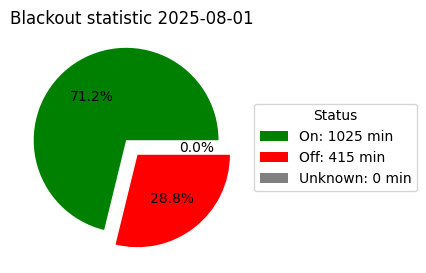

In [4]:
# Show Daily statistic as pie chart
# https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_features.html

labels_day = ['On', 'Off','Unknown']
label_percent = [0,0,0]
colors = ['green','red','grey']
for j in range(3):
    labels_day[j] = f'{labels_day[j]}: {values_day[j]} min'
    label_percent[j] = values_day[j] / (60*24) * 100 

fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

wedges, texts, autotext = ax.pie(values_day,autopct='%1.1f%%' ,colors=colors, explode=(0.1,0.1,0.1),   )
ax.legend(wedges, labels_day,
          title="Status",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
# plt.setp( size=8, weight="bold")

ax.set_title(f"Blackout statistic {date_day}")

plt.show()



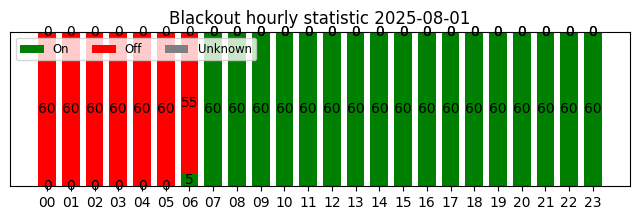

In [5]:
# Show hourly statistic as bar chart
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/horizontal_barchart_distribution.htm

colors = ['green','red','grey']
labels_y = ['On', 'Off','Unknown']

labels_x =  np.array(list(values_hours.keys()))
values = np.array(list(values_hours.values()))
label_percent = [0,0,0]

fig, ax = plt.subplots(figsize=(8, 2))
# ax.invert_xaxis()
ax.yaxis.set_visible(False)
ax.set_ylim(0, 60)

# ax.invert_yaxis()
# ax.xaxis.set_visible(False)
# ax.set_xlim(0, 60)

data_cum = values.cumsum(axis=1)

for j in range(3):
        heights = values[:, j]
        # widths = data_cum[:, j]
        # labels_x_tmp = labels_x.copy()
        starts = data_cum[:, j] - heights
        labels_x_tmp = labels_x.copy()
     
        
        # rects = ax.barh(labels_x_tmp, widths, left=starts, height=0.75,
        #                 label=labels_y[j], color=colors[j])
                             
        rects = ax.bar(labels_x_tmp, heights,bottom=starts , width=0.75,
                        label=labels_y[j], color=colors[j])
        ax.bar_label(rects, label_type='center', color='black')

ax.legend(ncols=len(labels_y), bbox_to_anchor=(0, 1),
            loc='upper left', fontsize='small')

ax.set_title(f"Blackout hourly statistic {date_day}")

plt.show()



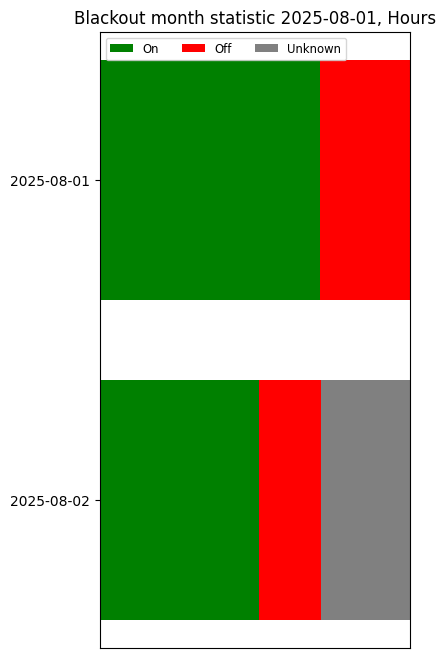

In [6]:
# Show month statistic as bar chart
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/horizontal_barchart_distribution.htm

colors = ['green','red','grey']
labels_y = ['On', 'Off','Unknown']

labels_x =  np.array(list(values_month.keys()))
values = np.array(list(values_month.values()))
label_percent = [0,0,0]

fig, ax = plt.subplots(figsize=(4, 8))

ax.invert_yaxis()
ax.xaxis.set_visible(False)
ax.set_xlim(0, 24)

data_cum = values.cumsum(axis=1)

for j in range(3):
        heights = values[:, j]
        # labels_x_tmp = labels_x.copy()
        starts = data_cum[:, j] - heights
        labels_x_tmp = labels_x.copy()
     
        
        rects = ax.barh(labels_x_tmp, heights, left=starts, height=0.75,
                        label=labels_y[j], color=colors[j])
                             
       
        # ax.bar_label(rects, label_type='center', color='black')

ax.legend(ncols=len(labels_y), bbox_to_anchor=(0, 1),
            loc='upper left', fontsize='small')

ax.set_title(f"Blackout month statistic {date_day}, Hours")

plt.show()



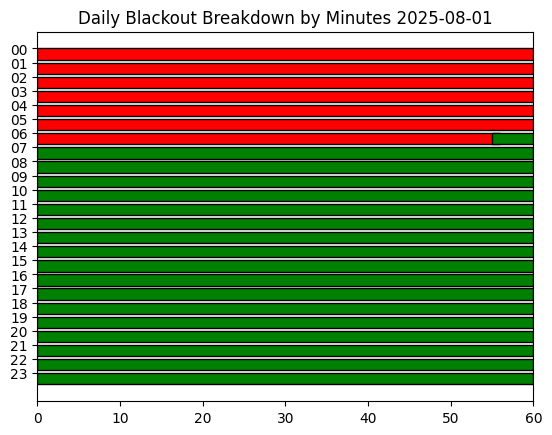

In [7]:
# Broken horizontal bars
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/broken_barh.html#sphx-glr-gallery-lines-bars-and-markers-broken-barh-py

colors = {1:'green',0:'red',-1:'grey'}

fig, ax = plt.subplots()

for hour in values_day_minutes.keys():
    values_mins = values_day_minutes[hour]
    duration = 1
    start = 0
    last_value = values_mins[0]
    # c = colors[last_value]
    face_colors = [ ]
    seq = [] #  sequence of (start, duration) tuples
    for j in range(1, len(values_mins)):
        duration += 1
        if values_mins[j] != last_value: # if the value changed
            if last_value >= 0: 
                face_colors.append(colors[last_value])
                seq.append((start, duration))
            start = j
            duration = 1
            last_value = values_mins[j]
    if last_value >= 0:
        seq.append((start, duration))
        face_colors.append(colors[last_value])
    ax.broken_barh(seq,(int(hour), 0.8) ,  color=face_colors, edgecolor='black')
     

ax.set_xlim(0, 60)
ax.set_yticks(range(len(values_day_minutes.keys())), labels=values_day_minutes.keys())
ax.invert_yaxis()
ax.set_title(f"Daily Blackout Breakdown by Minutes {date_day}")

plt.show()